# Komet with Uniprot LAkernel

1. Downloading the dataset (train/val/test) : you can choose different databases
2. Calculating of molecule features using a subsample of train molecules (MorganFP kernel approximated via Nystrom approximation)
3. Loading approximated protein features, using SVD of the Local Alignment kernel precalculated on 20605 human proteins
4. Searching for the best lambda by choosing the best AUPR on the validation dataset
5. Testing with best lambda

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import pickle

import time

from sklearn.metrics import  average_precision_score,  roc_curve, confusion_matrix, precision_score, recall_score, auc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
device_cpu = device
print( device )

mytype = torch.float16 # to save memory (only on GPU)
mytype = torch.float32

cuda:0


In [2]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 28.8 MB/s eta 0:00:00


### 1. Download from a GitHub repo.

#### Download utils

In [3]:
!wget -q https://github.com/Guichaoua/komet/raw/main/komet/komet.py

In [4]:
import komet

cuda:0


#### Download train/val/test
Exemples of dataset :
* LCIdb/Orphan,
* BIOSNAP(full_data,unseen_drug, unseen_protein),
* BindingDB.
  
These last datasets can be also downloaded on MolTrans Github ex: https://raw.githubusercontent.com/kexinhuang12345/MolTrans/master/dataset/DAVIS/test.csv)

In [5]:
!mkdir data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/LCIdb/Orphan/test.csv
!mv test.csv data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/LCIdb/Orphan/train.csv.zip
!mv train.csv.zip data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/LCIdb/Orphan/val.csv
!mv val.csv data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/dict_ind2fasta_all.data
!mv dict_ind2fasta_all.data data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/U_small.npy
!mv U_small.npy data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/Lambda_small.npy
!mv Lambda_small.npy data/

In [6]:
dataset_dir = "data/"

# load data
train = komet.load_df("train.csv.zip",dataset_dir)
val = komet.load_df("val.csv",dataset_dir)
test = komet.load_df("test.csv",dataset_dir)

# dataframe full has all smiles and fasta sequences
full = pd.concat([train, val, test])
print("full shape",full.shape)

number of smiles to clean: 0
train.csv shape (236530, 3)
number of smiles to clean: 0
val.csv shape (21844, 3)
number of smiles to clean: 0
test.csv shape (45005, 3)
full shape (303379, 3)


### 2. Calculation of molecule features using a subsample of train molecules (molecule kernel approximated via Nystrom approximation)

In [7]:
#### MOLECULE####
# Index of the smiles in the dataset
list_smiles = full[['SMILES']].drop_duplicates().values.flatten()
nM = len(list_smiles)
print("number of different smiles (mol):",nM)
dict_smiles2ind = {list_smiles[i]:i for i in range(nM)}

# add indsmiles in train, val, test
train['indsmiles'] = train['SMILES'].apply(lambda x:dict_smiles2ind[x] )
val['indsmiles'] = val['SMILES'].apply(lambda x: dict_smiles2ind[x])
test['indsmiles'] = test['SMILES'].apply(lambda x: dict_smiles2ind[x])

number of different smiles (mol): 143255


In [8]:
# Choice of the parameters for the Nystrom approximation and the reduction dimension of the features
mM = 3000 #all mol to compute the mol kernel for medium-scale database
dM = 1000 #all dim for the mol features for medium-scale database

# In case there are less molecules than the number of molecules to compute the Nystrom approximation
mM = min(mM,nM) # number of molecule to compute nystrom
dM = min(dM,nM) # final dimension of features for molecules
print("mM",mM,"dM",dM)

mM 3000 dM 1000


In [9]:
# molecule kernel_first step : computation of Morgan fingerprint for all molecules
MorganFP = komet.Morgan_FP(list_smiles)

# compute the Nystrom approximation of the mol kernel and the features of the Kronecker kernel (features normalized and calculated on all mol contained in the dataset (train/val/test))
X_cn = komet.Nystrom_X_cn(mM,dM,nM,MorganFP,n_max = max(train['indsmiles']))
print("mol features shape",X_cn.shape)

mol kernel shape torch.Size([3000, 143255])
mol features shape torch.Size([143255, 1000])


### 3. Approximated protein features, using SVD of the Local Alignment kernel precalculated on 20605 human proteins

$K_P = U \Lambda U.T$  

With file size constraints on Github, we can only load $U_{small} = U[:,:1200]$ and $\Lambda_{small} = \Lambda[:,:1200]$

You can look in dict_ind2fasta_all.data which proteins are present.

In [10]:
# Load Precomputed kernel and dict for the proteins
dict_ind2fasta_all = pickle.load(open("data/dict_ind2fasta_all.data", 'rb'))
dict_fasta2ind_all = {fasta:ind for ind,fasta in dict_ind2fasta_all.items()}
U = torch.from_numpy(np.load("data/U_small.npy"))
Lambda = torch.from_numpy(np.load("data/Lambda_small.npy"))
print("U.shape",U.shape,"Lambda.shape",Lambda.shape)

U.shape torch.Size([20605, 1200]) Lambda.shape torch.Size([1200])


In [11]:
# computation of feature for protein (no nystrom, just SVD)
dP = min(U.shape[0],1200)
Y_all = U[:,:dP] @ torch.diag(torch.sqrt(Lambda[:dP]))
Y_all = U[:,:dP] @ torch.diag(torch.sqrt(Lambda[:dP]))
Y_all = Y_all.to(device)

In [12]:
# Index of the protein in the dataset
fasta = full[['Target Sequence']].drop_duplicates().values.flatten() # fasta sequence on the dataset, in the same order as the dataset
print("number of different Fasta (protein):",len(fasta))
# add ind_fasta dans train, val et test
train['indfasta'] = train['Target Sequence'].apply(lambda x: np.where(fasta==x)[0][0])
val['indfasta'] = val['Target Sequence'].apply(lambda x: np.where(fasta==x)[0][0])
test['indfasta'] = test['Target Sequence'].apply(lambda x:  np.where(fasta==x)[0][0])

number of different Fasta (protein): 2069


In [13]:
I_fasta = [int(dict_fasta2ind_all[fasta[i]]) for i in range(len(fasta))] # indeY of fasta in the precomputed dict and protein kernel, in the same order as the dataset
Y = Y_all[I_fasta,:]
Y = torch.tensor(Y,dtype = mytype,device = device)
n_max = max(train['indfasta'])
Y_c = Y - Y[:n_max,:].mean(axis = 0)
Y_cn = Y_c / torch.norm(Y_c,dim = 1)[:,None]
print("features shape",Y_cn.shape)

features shape torch.Size([2069, 1200])


<ipython-input-13-02af9936bc10>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y,dtype = mytype,device = device)


#### INDEX OF INTERACTIONS

In [14]:
# TRAIN
I, J, y = komet.load_datas(train)
n = len(I)
print("len(train)",n)

len(train) 236530


### 4. Komet algorithm


#### training with a choosen lambda

In [15]:
lamb = 0.01
# train the model
w_bfgs,b_bfgs,history_lbfgs_SVM = komet.SVM_bfgs(X_cn,Y_cn,y,I,J,lamb,niter=50)
# compute a probability using weights (Platt scaling)
s,t,history_lbfgs_Platt = komet.compute_proba_Platt_Scalling(w_bfgs,X_cn,Y_cn,y,I,J,niter=20)

L-BFGS time: 5.8838 seconds


In [16]:
# Validation
I_val, J_val, y_val = komet.load_datas(val)
n_val = len(I_val)
print("len(val)",n_val)

len(val) 21844


In [17]:
#### val ####
# we compute a probability using weights (Platt scaling)
m,y_pred, proba_pred = komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I_val,J_val)
# we compute the results
acc1,au_Roc,au_PR,thred_optim,acc_best,cm,FP = komet.results(y_val.cpu(),y_pred.cpu(),proba_pred.cpu())
print(f"roc AUC = {au_Roc:.4f}")
print(f"AUPR = {au_PR:.4f}")
print(f"accuracy (threshold 0.5)= {acc1:.4f}")
print(f"best threshold = {thred_optim:.4f}")
print(f"accuracy (best threshold)= {acc_best:.4f}")
print(f"false positive (best threshold)= {FP:.4f}")

roc AUC = 0.7556
AUPR = 0.7649
accuracy (threshold 0.5)= 0.5000
best threshold = 0.3497
accuracy (best threshold)= 0.6925
false positive (best threshold)= 0.3917


### Choice of $\lambda$:  Search for the best lambda by choosing the best AUPR on the validation dataset

In [18]:
#### Choice of the hyperparameters ####
# we use the validation set to choose the hyperparameters
# we use the AUPR as a criterion
lambdas = np.logspace(-11, 2, num=14)
accs = []
aupr = []
lambda_max = 0
aupr_max = 0

for lamb in lambdas:
    print("lambda=",lamb)

    # train the model
    w_bfgs,b_bfgs,history_lbfgs_SVM = komet.SVM_bfgs(X_cn,Y_cn,y,I,J,lamb,niter=50)
    # compute a probability using weights (Platt scaling)
    s,t,history_lbfgs_Platt = komet.compute_proba_Platt_Scalling(w_bfgs,X_cn,Y_cn,y,I,J,niter=20)

    # accuracy on the validation set
    m,y_pred_val, proba_pred_val = komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I_val,J_val)
    # we compute the results
    acc1,au_Roc,au_PR,thred_optim,acc_best,cm,FP = komet.results(y_val.cpu(),y_pred_val.cpu(),proba_pred_val.cpu())

    accs.append(acc1)
    aupr.append(au_PR)

    if au_PR > aupr_max:
        lambda_max=lamb
        aupr_max = au_PR

print("-"*30)
print("lambda_max",lambda_max)
print("aupr_max for val",aupr_max)


lambda= 1e-11
L-BFGS time: 11.6659 seconds
lambda= 1e-10
L-BFGS time: 11.8968 seconds
lambda= 1e-09
L-BFGS time: 11.7499 seconds
lambda= 1e-08
L-BFGS time: 12.1045 seconds
lambda= 1e-07
L-BFGS time: 12.0310 seconds
lambda= 1e-06
L-BFGS time: 12.0544 seconds
lambda= 1e-05
L-BFGS time: 12.3243 seconds
lambda= 0.0001
L-BFGS time: 12.3547 seconds
lambda= 0.001
L-BFGS time: 6.4322 seconds
lambda= 0.01
L-BFGS time: 3.9367 seconds
lambda= 0.1
L-BFGS time: 3.6088 seconds
lambda= 1.0
L-BFGS time: 3.6306 seconds
lambda= 10.0
L-BFGS time: 3.6039 seconds
lambda= 100.0
L-BFGS time: 3.5971 seconds
------------------------------
lambda_max 1e-05
aupr_max for val 0.8511095652601627


Plot accuracy in function of lambda

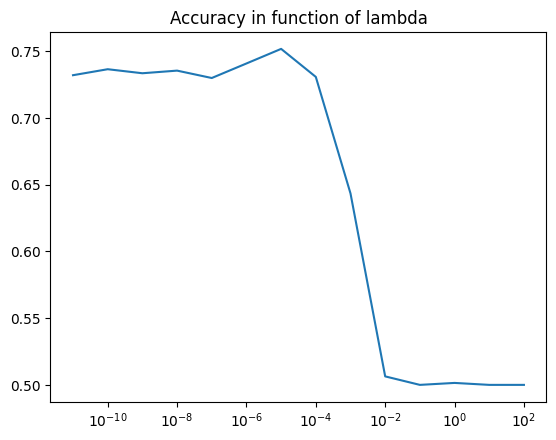

In [19]:
import matplotlib.pyplot as plt
plt.plot(lambdas,accs)
plt.xscale('log')
plt.title('Accuracy in function of lambda')
plt.show()

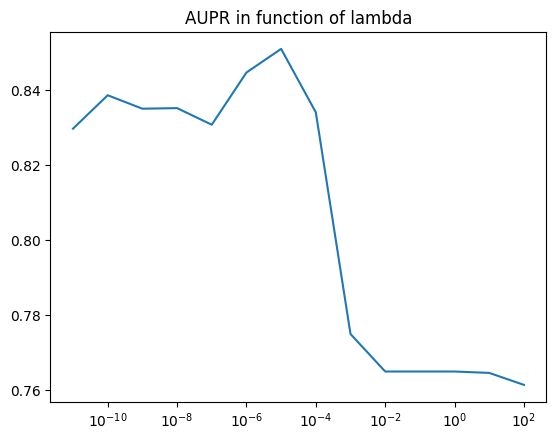

In [20]:
plt.plot(lambdas,aupr)
plt.xscale('log')
plt.title('AUPR in function of lambda')
plt.show()

### Training/testing with lambda_max

In [21]:
lamb = lambda_max
print("lambda_max=",lamb)
# train the model
w_bfgs,b_bfgs,history_lbfgs_SVM = komet.SVM_bfgs(X_cn,Y_cn,y,I,J,lamb,niter=50)
# compute a probability using weights (Platt scaling)
s,t,history_lbfgs_Platt = komet.compute_proba_Platt_Scalling(w_bfgs,X_cn,Y_cn,y,I,J,niter=20)

lambda_max= 1e-05
L-BFGS time: 12.1627 seconds


In [22]:
# Test
I_test, J_test, y_test = komet.load_datas(test)
n_test = len(I_test)
print("len(test)",n_test)

len(test) 45005


In [23]:
#### TEST ####
# we compute a probability using weights (Platt scaling)
m,y_pred, proba_pred = komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I_test,J_test)
# we compute the results
acc1,au_Roc,au_PR,thred_optim,acc_best,cm,FP = komet.results(y_test.cpu(),y_pred.cpu(),proba_pred.cpu())
print(f"roc AUC = {au_Roc:.4f}")
print(f"AUPR = {au_PR:.4f}")
print(f"accuracy (threshold 0.5)= {acc1:.4f}")
print(f"best threshold = {thred_optim:.4f}")
print(f"accuracy (best threshold)= {acc_best:.4f}")
print(f"false positive (best threshold)= {FP:.4f}")

roc AUC = 0.8625
AUPR = 0.8726
accuracy (threshold 0.5)= 0.7828
best threshold = 0.1004
accuracy (best threshold)= 0.8002
false positive (best threshold)= 0.1670


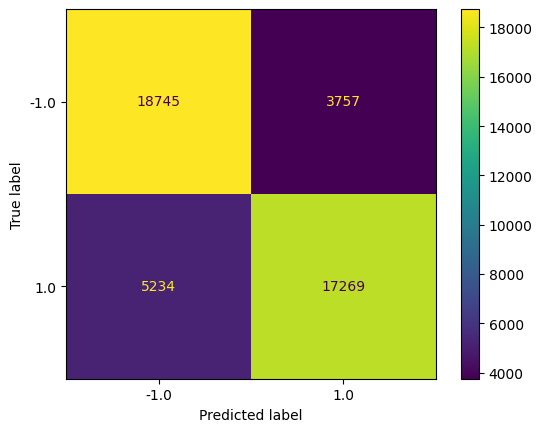

In [24]:
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels = [-1., 1.]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

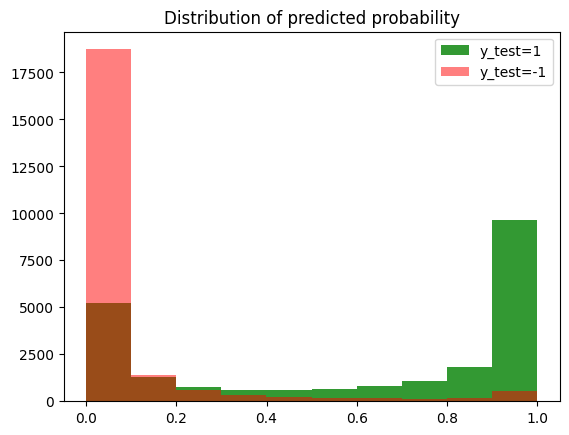

In [25]:
# plot distribution (density) of p when y_test=1
plt.hist(proba_pred.cpu().numpy()[y_test.cpu().numpy()==1],bins=10,alpha=0.8,color='green',label='y_test=1');
plt.hist(proba_pred.cpu().numpy()[y_test.cpu()==-1],bins=10,alpha=0.5,color='red',label='y_test=-1');
plt.legend()
plt.title('Distribution of predicted probability')
plt.show()